In [476]:
import re
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

from wordcloud import WordCloud
from kiwipiepy import Kiwi


### Config 로드

In [477]:
with open("config.yaml", "r", encoding="utf-8") as f:
    cfg = yaml.safe_load(f)

csv_path = cfg["paths"]["csv_path"]
TEXT_COL = cfg["columns"]["text_col"]
BRANCH_COL = cfg["columns"]["branch_col"]

SENTIMENT_COL = cfg["columns"]["sentiment_col"]
POS_LABEL = cfg["labels"]["pos"]
NEG_LABEL = cfg["labels"]["neg"]

wc_cfg = cfg["wordcloud"]
FONT_PATH = wc_cfg["font_path"]
MAX_WORDS = int(wc_cfg["max_words"])
RANDOM_STATE = int(wc_cfg["random_state"])
WC_W = int(wc_cfg.get("width", 900))
WC_H = int(wc_cfg.get("height", 600))
BG = wc_cfg.get("background_color", "white")

MATPLOT_FONT = cfg["matplotlib"]["font"]

min_chars = int(cfg["filtering"]["min_chars"])
noun_only = bool(cfg["filtering"]["noun_only"])
min_token_len = int(cfg["filtering"].get("min_token_len", 2))
min_reviews = int(cfg["filtering"]["min_reviews"])

STOPWORDS = set(cfg.get("stopwords", []))
SYN_MAP = cfg.get("syn_map", {})

### 정규화 함수

In [478]:
def is_long_enough(text: str) -> bool:
    return isinstance(text, str) and len(text.strip()) >= min_chars

def normalize_token(token: str) -> str:
    # 1) 문자열 보장
    token = str(token)

    # 3) 보이지 않는 문자 제거
    token = token.replace("\u200b", "").replace("\ufeff", "")

    # 4) 공백 정리
    token = token.strip()
    token = re.sub(r"\s+", " ", token)

    # 5) 동의어/표기 통일
    token = SYN_MAP.get(token, token)

    return token


### 토큰화

In [479]:
kiwi = Kiwi()

def kiwi_tokenize(text: str) -> str:
    text = str(text)
    text = re.sub(r"\s+", " ", text).strip()

    tokens = set()

    for t in kiwi.tokenize(text):
        form, tag = t.form, t.tag

        if len(form) < min_token_len:
            continue

        if form in STOPWORDS:
            continue

        form = normalize_token(form)

        if form in STOPWORDS:
            continue

        if noun_only:
            keep = tag in {"NNG", "NNP", "NR", "NP"}
        else:
            keep = tag in {"NNG", "NNP", "NR", "NP", "VV", "VA"}

        if keep:
            tokens.add(form)

    return " ".join(tokens)

Quantization is not supported for ArchType::neon. Fall back to non-quantized model.


### 파일 로드

In [480]:
# 데이터 로드 + 문서 길이 필터
df = pd.read_csv(csv_path)

pos_series = df.loc[df[SENTIMENT_COL] == POS_LABEL, TEXT_COL].dropna()
pos_series = pos_series[pos_series.apply(is_long_enough)]

neg_series = df.loc[df[SENTIMENT_COL] == NEG_LABEL, TEXT_COL].dropna()
neg_series = neg_series[neg_series.apply(is_long_enough)]

# corpus 생성
pos_corpus = " ".join(pos_series.map(kiwi_tokenize))
neg_corpus = " ".join(neg_series.map(kiwi_tokenize))

In [481]:
# WordCloud 생성
wc_pos = WordCloud(
    font_path=FONT_PATH,
    background_color=BG,
    max_words=MAX_WORDS,
    random_state=RANDOM_STATE,
    width=WC_W,
    height=WC_H,
    collocations=False
).generate(pos_corpus)

wc_neg = WordCloud(
    font_path=FONT_PATH,
    background_color=BG,
    max_words=MAX_WORDS,
    random_state=RANDOM_STATE,
    width=WC_W,
    height=WC_H,
    collocations=False
).generate(neg_corpus)

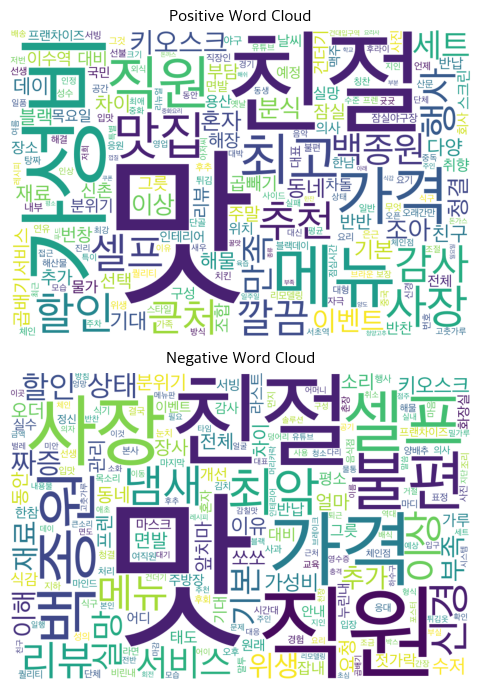

In [482]:
fig, axes = plt.subplots(2, 1, figsize=(16,7))

axes[0].imshow(wc_pos)
axes[0].set_title("Positive Word Cloud")
axes[0].axis("off")

axes[1].imshow(wc_neg)
axes[1].set_title("Negative Word Cloud")
axes[1].axis("off")

plt.tight_layout()
plt.show()

In [483]:
# 지점 × 감정 개수 집계
count_df = (
    df.groupby([BRANCH_COL, SENTIMENT_COL])
      .size()
      .unstack(fill_value=0)
)

total = count_df[[POS_LABEL, NEG_LABEL]].sum(axis=1)

# 비율 계산
ratio_df = count_df[[POS_LABEL, NEG_LABEL]].div(total, axis=0) * 100

# total 컬럼 추가
count_df["total"] = total

In [484]:
negative_top10 = (
    ratio_df[count_df["total"] >= min_reviews]
    .sort_values(by=NEG_LABEL, ascending=False)
    .head(10)
    .assign(total=count_df["total"])
)

positive_top10 = (
    ratio_df[count_df["total"] >= min_reviews]
    .sort_values(by=POS_LABEL, ascending=False)
    .head(10)
    .assign(total=count_df["total"])
)

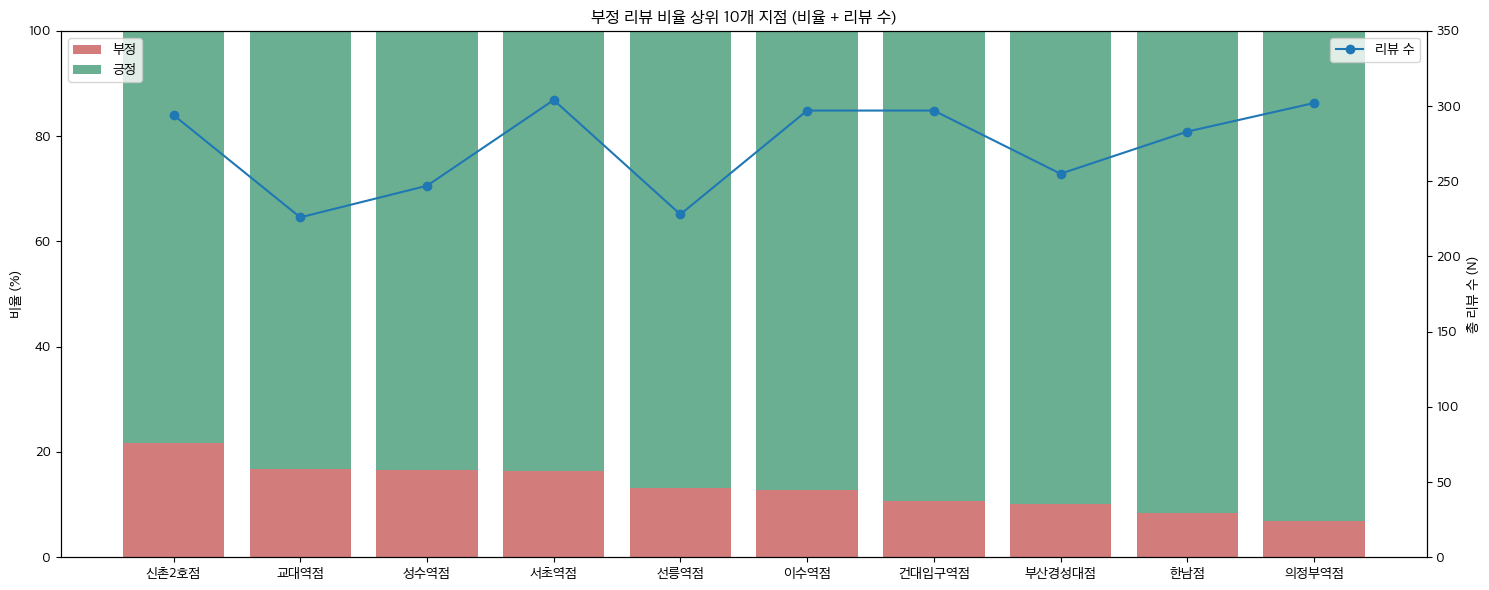

In [485]:
def plot_stacked_with_count(df, title):
    fig, ax1 = plt.subplots(figsize=(15, 6))

    POS_COLOR = "#6BAF92"   # muted green
    NEG_COLOR = "#D27C7C"   # muted red
    COUNT_COLOR = "#4C72B0" # muted blue

    # --- 누적 막대 (비율) ---
    ax1.bar(df.index, df[NEG_LABEL], label="부정", color=NEG_COLOR)
    ax1.bar(df.index, df[POS_LABEL], bottom=df[NEG_LABEL], label="긍정", color=POS_COLOR)

    ax1.set_ylabel("비율 (%)")
    ax1.set_ylim(0, 100)
    ax1.legend(loc="upper left")

    # --- 꺾은선 (리뷰 수) ---
    ax2 = ax1.twinx()
    ax2.plot(df.index, df["total"], marker="o", linestyle="-", label="리뷰 수")
    ax2.set_ylabel("총 리뷰 수 (N)")

    # --- 제목 & 축 ---
    plt.title(title)
    plt.xticks(rotation=45, ha="right")

    max_n = df["total"].max()
    upper = int(np.ceil(max_n / 50.0) * 50)

    ax2.set_ylim(0, upper)
    ax2.set_yticks(np.arange(0, upper + 1, 50))

    # 두 번째 범례
    ax2.legend(loc="upper right")

    plt.tight_layout()
    plt.show()


plt.rcParams["font.family"] = MATPLOT_FONT

plot_stacked_with_count(
    negative_top10,
    title="부정 리뷰 비율 상위 10개 지점 (비율 + 리뷰 수)"
)

In [486]:
worst_branch = negative_top10.index[0]

worst_neg_reviews = (
    df[
        (df[BRANCH_COL] == worst_branch) &
        (df[SENTIMENT_COL] == NEG_LABEL)
    ][TEXT_COL]
    .dropna()
)

worst_neg_reviews = worst_neg_reviews[
    worst_neg_reviews.apply(is_long_enough)
]

worst_neg_corpus = " ".join(
    worst_neg_reviews.map(kiwi_tokenize)
)

wc_neg_branch = WordCloud(
    font_path=FONT_PATH,
    background_color="white",
    max_words=150,
    width=900,
    height=600,
    collocations=False
).generate(worst_neg_corpus)


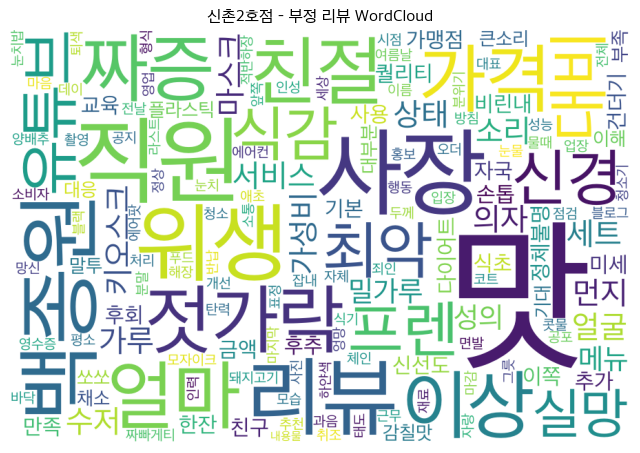

In [487]:
plt.figure(figsize=(8, 6))
plt.imshow(wc_neg_branch)
plt.axis("off")
plt.title(f"{worst_branch} – 부정 리뷰 WordCloud")
plt.show()

In [489]:
def search_reviews(df, branch=None, sentiment=None, keyword=None,
                   branch_col="지점명", sentiment_col="감정", text_col="리뷰내용"):
    result = df.copy()
    # 지점 필터
    if branch and branch != "전체":
        result = result[result[branch_col] == branch]
    # 감정 필터
    if sentiment and sentiment != "전체":
        result = result[result[sentiment_col] == sentiment]
    # 키워드 필터
    if keyword and keyword.strip() != "":
        result = result[result[text_col].astype(str).str.contains(keyword, na=False)]
    return result

branch = input(":편의점: 지점을 입력하세요 (전체 / 신촌2호점 등): ").strip()
sentiment = input(":미소짓는_상기된_얼굴: 감정을 선택하세요 (전체 / 긍정 / 부정): ").strip()
keyword = input(":돋보기: 찾을 키워드를 입력하세요: ").strip()
result_df = search_reviews(df, branch=branch, sentiment=sentiment, keyword=keyword)
print(f"\n조건에 맞는 댓글 수: {len(result_df)}")
result_df[["지점명", "닉네임", "리뷰내용", "감정"]]


조건에 맞는 댓글 수: 2


,지점명,닉네임,리뷰내용,감정
43,신촌2호점,wwsshh86,어쩔수없이 리뷰를 써야겠네요\n유튜브보고 괜찮아졌을까 기대하고 갔건만..당했네요.\...,부정
75,신촌2호점,일렉92,유튜브보고 두툼한 계란이 먹고싶어 갔는데 홍보용 계란두께하고 많이 다른 모습에 실망...,부정
